# SOLAR POWER PREDICTION

## Importing relevant libraries


In [2]:
!pip install facets-overview
import numpy as np
import pandas as pd
import matplotlib as plt
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML
import base64
from sklearn.preprocessing import LabelEncoder
from sys import getsizeof
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import norm
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploring the data

In [3]:
dfp1 = pd.read_csv('/content/drive/MyDrive/Frescando com dados solares/Plant_1_Generation_Data.csv')
dfw1 = pd.read_csv('/content/drive/MyDrive/Frescando com dados solares/Plant_1_Weather_Sensor_Data.csv')

In [4]:
dfw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [5]:
dfp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [6]:
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': dfp1}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [7]:
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': dfw1}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [8]:
dfp1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [9]:
dfw1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [10]:
def optimize_df(df):
  if df.columns[0].isupper():
    #getting the initial size
    initial_size = getsizeof(df)
    sup_df = pd.DataFrame({})

    #transform columns to lowercase
    lower_case = lambda columns: columns.lower()
    df.columns = map(lower_case, df.columns)

    #encoding the ids
    le = LabelEncoder()
    le.fit(np.unique(df.source_key))
    df['source_key'] = np.array(le.transform(df.source_key.values), dtype=np.int8)
    sup_df['source_key'] = le.classes_
    sup_df['plant_id'] = df['plant_id']
    df = df.drop(columns=['plant_id'])

    #change datetime from string to datetime
    df['date_time'] = pd.to_datetime(df['date_time'])

    final_size = getsizeof(df)

    print('Initial size: {} Mb'.format(initial_size/1e6))
    print('Final size:    {} Mb'.format(final_size/1e6))
    print('Memory footprint reduction: {}%'.format((initial_size - final_size)/initial_size*100))
  else:
    print('Data Frame is already optimized')
  return df, sup_df

In [11]:
dfp1, dfp1_sup = optimize_df(dfp1)

Initial size: 12.72409 Mb
Final size:    2.820058 Mb
Memory footprint reduction: 77.836859060255%


As the weather dataframe have the same format, we can optimize using the same fuction

In [12]:
dfw1, dfw1_sup = optimize_df(dfw1)

Initial size: 0.57292 Mb
Final size:    0.105166 Mb
Memory footprint reduction: 81.64385952663548%


In [13]:
dfp1.head()

,date_time,source_key,dc_power,ac_power,daily_yield,total_yield
0,2020-05-15,0,0.0,0.0,0.0,6259559.0
1,2020-05-15,1,0.0,0.0,0.0,6183645.0
2,2020-05-15,2,0.0,0.0,0.0,6987759.0
3,2020-05-15,3,0.0,0.0,0.0,7602960.0
4,2020-05-15,4,0.0,0.0,0.0,7158964.0


In [14]:
dfp1.tail()

,date_time,source_key,dc_power,ac_power,daily_yield,total_yield
68773,2020-06-17 23:45:00,17,0.0,0.0,5967.000,7287002.0
68774,2020-06-17 23:45:00,18,0.0,0.0,5147.625,7028601.0
68775,2020-06-17 23:45:00,19,0.0,0.0,5819.000,7251204.0
68776,2020-06-17 23:45:00,20,0.0,0.0,5817.000,6583369.0
68777,2020-06-17 23:45:00,21,0.0,0.0,5910.000,7363272.0


In [15]:
dfp1.describe()

,source_key,dc_power,ac_power,daily_yield,total_yield
count,68778.000000,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,10.496787,3147.426211,307.802752,3295.968737,6.978712e+06
std,6.345209,4036.457169,394.396439,3145.178309,4.162720e+05
min,0.000000,0.000000,0.000000,0.000000,6.183645e+06
25%,5.000000,0.000000,0.000000,0.000000,6.512003e+06
50%,11.000000,429.000000,41.493750,2658.714286,7.146685e+06
75%,16.000000,6366.964286,623.618750,6274.000000,7.268706e+06
max,21.000000,14471.125000,1410.950000,9163.000000,7.846821e+06


In [16]:
dfw1.head()

,date_time,source_key,ambient_temperature,module_temperature,irradiation
0,2020-05-15 00:00:00,0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0,24.621525,22.165423,0.0


In [17]:
dfw1.tail()

,date_time,source_key,ambient_temperature,module_temperature,irradiation
3177,2020-06-17 22:45:00,0,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,0,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,0,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,0,21.969495,20.734963,0.0
3181,2020-06-17 23:45:00,0,21.909288,20.427972,0.0


In [18]:
dfw1.describe()

,source_key,ambient_temperature,module_temperature,irradiation
count,3182.0,3182.000000,3182.000000,3182.000000
mean,0.0,25.531606,31.091015,0.228313
std,0.0,3.354856,12.261222,0.300836
min,0.0,20.398505,18.140415,0.000000
25%,0.0,22.705182,21.090553,0.000000
50%,0.0,24.613814,24.618060,0.024653
75%,0.0,27.920532,41.307840,0.449588
max,0.0,35.252486,65.545714,1.221652


In [19]:
fig = make_subplots(
    rows=4, cols=2,
    specs=[[{"colspan":2}, None],
           [{}, {}],
           [{}, {}],
           [{}, {}]],
    print_grid=True)

fig.add_trace(go.Box(x=dfp1["dc_power"], name='DC power'),
              row=1, col=1)

fig.add_trace(go.Box(x=dfp1["ac_power"], name="AC power"),
              row=2, col=1)

fig.add_trace(go.Box(x=dfp1["daily_yield"], name="Daily Yield"),
              row=2, col=2)

fig.add_trace(go.Box(x=dfp1["total_yield"], name="Total Yield"),
              row=3, col=1)

fig.add_trace(go.Box(x=dfw1["ambient_temperature"], name="Ambient temperature"),
              row=3, col=2)

fig.add_trace(go.Box(x=dfw1["module_temperature"], name="Module temperature"),
              row=4, col=1)

fig.add_trace(go.Box(x=dfw1["irradiation"], name="Irradiation"),
              row=4, col=2)


fig.update_yaxes(visible=False, showticklabels=False)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [20]:
dfp1['ac_power'].mean()/dfp1['dc_power'].mean()

0.09779506543078857

In [21]:
dfp1['ac_power'] = dfp1['ac_power']*10

In [22]:
dfp1['ac_power'].mean()/dfp1['dc_power'].mean()

0.9779506543078856

In [23]:
fig = make_subplots(
    rows=7, cols=1)

fig.add_trace(go.Line(y=dfp1.dc_power[dfp1['source_key'] == 0], name='DC power'),
              row=1, col=1)

fig.add_trace(go.Line(y=dfp1.ac_power[dfp1['source_key'] == 0], name="AC power"),
              row=2, col=1)

fig.add_trace(go.Line(y=dfp1.daily_yield[dfp1['source_key'] == 0], name="Daily Yield"),
              row=3, col=1)

fig.add_trace(go.Line(y=dfp1.total_yield[dfp1['source_key'] == 0], name="Total Yield"),
              row=4, col=1)

fig.add_trace(go.Line(y=dfw1["ambient_temperature"], name="Ambient temperature"),
              row=5, col=1)

fig.add_trace(go.Line(y=dfw1["module_temperature"], name="Module temperature"),
              row=6, col=1)

fig.add_trace(go.Line(y=dfw1["irradiation"], name="Irradiation"),
              row=7, col=1)


fig.update_layout(
    autosize=False,
    width=1200,
    height=4000)

fig.update_yaxes(visible=False, showticklabels=False)

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [24]:
dfp1[dfp1['dc_power'] > 0]

,date_time,source_key,dc_power,ac_power,daily_yield,total_yield
510,2020-05-15 06:00:00,0,37.142857,35.857143,0.000000,6259559.000
511,2020-05-15 06:00:00,1,53.500000,51.625000,0.000000,6183645.000
512,2020-05-15 06:00:00,2,58.000000,55.857143,0.000000,6987759.000
513,2020-05-15 06:00:00,3,58.428571,56.285714,0.000000,7602960.000
514,2020-05-15 06:00:00,4,54.375000,52.500000,0.000000,7158964.000
...,...,...,...,...,...,...
68311,2020-06-17 18:30:00,17,79.000000,76.142857,5966.142857,7287001.143
68312,2020-06-17 18:30:00,18,75.714286,73.000000,5882.714286,7028600.714
68313,2020-06-17 18:30:00,19,77.428571,74.714286,5818.428571,7251203.429
68314,2020-06-17 18:30:00,20,74.857143,72.285714,5816.142857,6583368.143


In [25]:
dfp1[(dfp1['date_time'].dt.hour >= 23) | (dfp1['date_time'].dt.hour <= 1)]

,date_time,source_key,dc_power,ac_power,daily_yield,total_yield
0,2020-05-15 00:00:00,0,0.0,0.0,0.000,6259559.0
1,2020-05-15 00:00:00,1,0.0,0.0,0.000,6183645.0
2,2020-05-15 00:00:00,2,0.0,0.0,0.000,6987759.0
3,2020-05-15 00:00:00,3,0.0,0.0,0.000,7602960.0
4,2020-05-15 00:00:00,4,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...
68773,2020-06-17 23:45:00,17,0.0,0.0,5967.000,7287002.0
68774,2020-06-17 23:45:00,18,0.0,0.0,5147.625,7028601.0
68775,2020-06-17 23:45:00,19,0.0,0.0,5819.000,7251204.0
68776,2020-06-17 23:45:00,20,0.0,0.0,5817.000,6583369.0


In [26]:
dfp1.loc[(dfp1.date_time.dt.hour > 18) & (dfp1.daily_yield == 0)]

,date_time,source_key,dc_power,ac_power,daily_yield,total_yield
1779,2020-05-15 21:15:00,1,0.0,0.0,0.0,6190002.0
1780,2020-05-15 21:15:00,2,0.0,0.0,0.0,6994033.0
1781,2020-05-15 21:15:00,3,0.0,0.0,0.0,7609076.0
1783,2020-05-15 21:15:00,5,0.0,0.0,0.0,7212666.0
1784,2020-05-15 21:15:00,6,0.0,0.0,0.0,7034815.0
...,...,...,...,...,...,...
45585,2020-06-06 23:45:00,17,0.0,0.0,0.0,7208855.0
45586,2020-06-06 23:45:00,18,0.0,0.0,0.0,6953094.0
45587,2020-06-06 23:45:00,19,0.0,0.0,0.0,7177289.0
45588,2020-06-06 23:45:00,20,0.0,0.0,0.0,6506728.0


In [27]:
def standardize(df):
  #get minutes as hours
  df['hour'] = df['date_time'].dt.hour + df['date_time'].dt.minute/60

  #setting zero in all periods in abscence of light
  dfp1.loc[dfp1['hour'] <= 0, 'daily_yield'] = 0
  dfp1.loc[dfp1['hour'] >= 18.75, 'daily_yield'] = 0
  return df

In [28]:
dfp1 = standardize(dfp1)

In [29]:
px.line(dfp1[dfp1.source_key == 0]['daily_yield'])

In [30]:
merged_dfs = dfp1.merge(dfw1, on='date_time')

In [31]:
px.imshow(merged_dfs.corr())

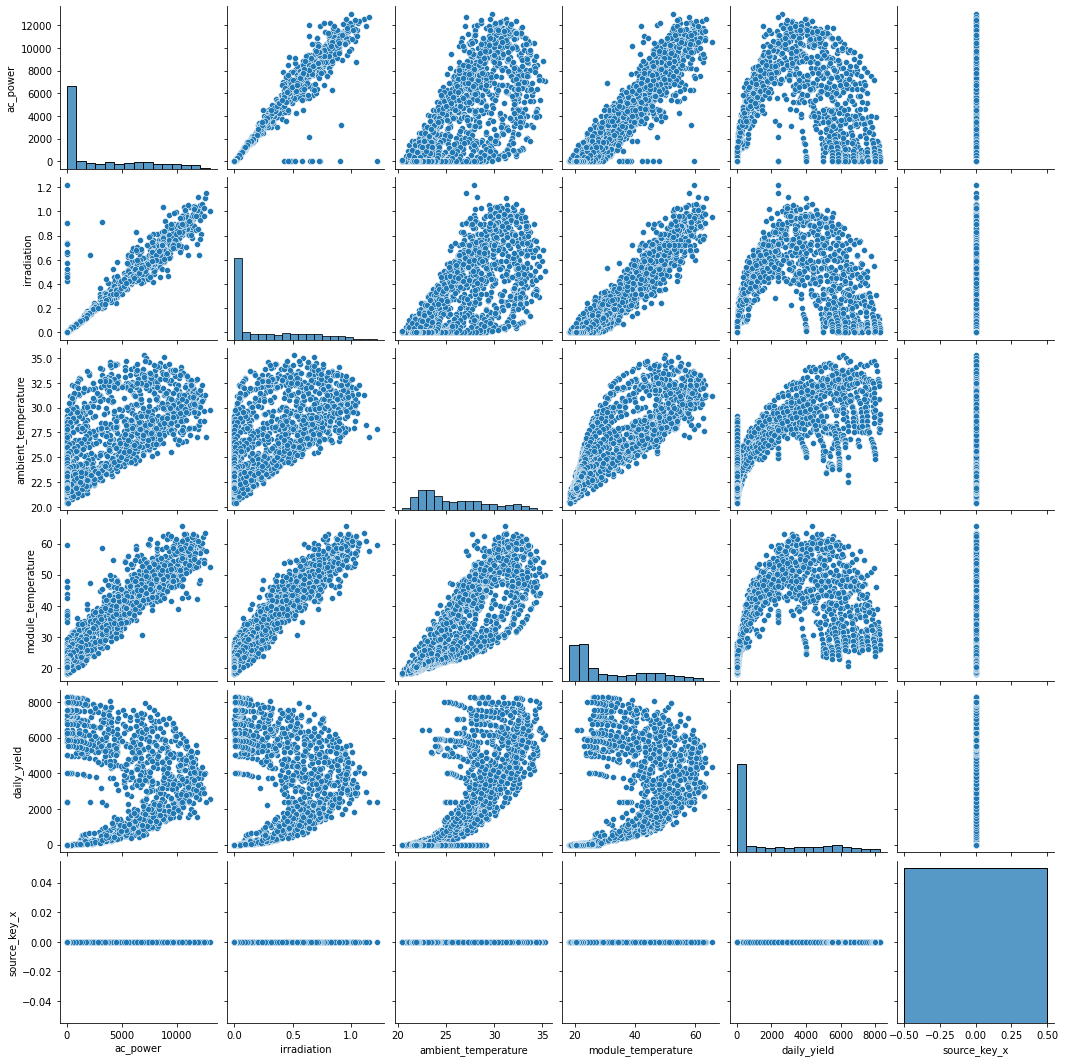

In [32]:
viz_df = merged_dfs[['ac_power', 'irradiation', 'ambient_temperature', 'module_temperature', 'daily_yield', 'source_key_x']]
sns.pairplot(viz_df[viz_df['source_key_x'] == 0])

$P = V_{th} × I_{N}(1)$ <br>
$V_{th} = V_{oc} × (1+ β (T_1-T_0))$<br>
$I_{N} = I_{sc} \times (1+α(T_1 - T_0))(G_1/G_0 )$<br>
$T_m=30−0.0175(G_{ir}−300)+1.14(T_a−25)$<br>
$P=K_1G^3_{ir}+K_2G^2_{ir}+K_3G^2_{ir}T_a+K_4G_{ir}T^2_a+K_5G_{ir}T_a+K_6G_{ir}$<br>


Variables<br>

T$_m$: Module temperature. <br>
T$_a$: Ambient temperature.<br>
G$_{ir}$: Ground level sun irradiance or Irradiation. <br>
P$_{ac}$: Power output (AC power).<br>
<br>
Constants<br>

T$_0$: 25oC. <br>
G$_0$: Standard Irradiation 1000 W/m2.<br>
α: Module electrical specification. <br>
β: Module electrical specification.<br>
V$_0$: Open circuit Voltage at Standard Conditions. <br>
I$_0$: Short circuit Current at Standard Conditions. <br>

Refferences.

[1] A novel Power Output Model for Photovoltaic Systems.
    Authors: Chiou-Jye Huang, Mao Ting Huang, Chung-Cheng Chen<br>
[2] Photovoltaic Engineering Handbook.
    Authors: France Lasnier, Tony Gan Ang.<br>
[3] Solar_power_plant_time_series_analysis_V5_01-22: https://www.kaggle.com/code/elbiopea/solar-power-plant-time-series-analysis-v5-01-22




In [33]:
X_pm = pd.DataFrame({'date_time': dfp1.date_time[dfp1['source_key'] == 0], 'ac_power': dfp1.ac_power[dfp1['source_key'] == 0]})
X_pm = X_pm.merge(dfw1)
X_pm['g3'] = X_pm['irradiation']**3
X_pm['g2'] = X_pm['irradiation']**2
X_pm['g2t'] = (X_pm['irradiation']**2)*X_pm['ambient_temperature']
X_pm['gt'] = (X_pm['irradiation'])*X_pm['ambient_temperature']
X_pm['g'] = (X_pm['irradiation'])*X_pm['ambient_temperature']
X_pm = X_pm.drop(columns=['module_temperature'])

In [34]:
px.imshow(X_pm.corr())

## Observations



---


A - 22 different values of source key, probably the plant have 22 grids of  solar panels with one inverter each. <br>
B - all column names are uppercase, it's easier to work with lowercase. <br>
C - The Source_id can be labeled to reduce the memory footprint <br>
D - The datetime column is stored as a string<br>
E - The data looks clean without outliers<br>
F - Inverters commomly have efficiency above 90%, probably the ac power is actually 10 times greater. <br>
G - The wave forms indicates the sun behaviour. The solar panels can't generate energy in the abscence of light <br>
H - The wave forms are not standardized, this can been seen more clearly in the daily yield, that have a plateau in the max value, but sometimes change abruptly in an unexpected time<br>
I - The energy generation occurs between 6:00 and 18:30<br>
J - The daily yield columns become zero at 00:00:00<br>
K - The relevant correlation features for prediction is irradiation, module temperature and ambient temperature, but we cand find only ambient temperature and irradiation in metheorological forecasting

## Creating and training malfunction detection model

In [35]:
def get_features(df, df0):
  
  #get physics-based features
  X_pm = []
  y_pm = []
  for i in np.unique(df.source_key.values):
    X = pd.DataFrame({'date_time': df.date_time[(df['source_key'] == i) & (df['hour']>=6) & (df['hour']<18.75)],
                      'ac_power': df.ac_power[(df['source_key'] == i) & (df['hour']>=6) & (df['hour']<18.75)],
                      'hour':df.date_time[(df['source_key'] == i) & (df['hour']>=6) & (df['hour']<18.75)]})
    X = X.merge(df0)
    X['g3'] = X['irradiation']**3
    X['g2'] = X['irradiation']**2
    X['g2t'] = (X['irradiation']**2)*X['ambient_temperature']
    X['gt2'] = (X['irradiation'])*X['ambient_temperature']**2
    X['gt'] = (X['irradiation'])*X['ambient_temperature']
    X['g'] = (X['irradiation'])
    y_pm.append(X['ac_power'])
    X = X.drop(columns=['module_temperature', 'source_key', 'date_time', 'ac_power', 'hour', 'irradiation', 'ambient_temperature']).to_numpy()
    X_pm.append(X)

  #get simple linear models features
  X_sl = []
  y_sl = []
  for i in np.unique(df.source_key.values):
    X = pd.DataFrame({'date_time': df.date_time[(df['source_key'] == i) & (df['hour']>=6) & (df['hour']<18.75)],
                      'ac_power': df.ac_power[(df['source_key'] == i) & (df['hour']>=6) & (df['hour']<18.75)],
                      'hour':df.date_time[(df['source_key'] == i) & (df['hour']>=6) & (df['hour']<18.75)]})
    X = X.merge(df0)
    y_sl.append(X['ac_power'])
    X = X.drop(columns=['module_temperature', 'source_key', 'ac_power', 'hour', 'date_time']).to_numpy()
    X_sl.append(X)
  return X_pm, y_pm, X_sl, y_sl


In [36]:
def train_linear_models(X, y):
  
  #training physics-based model
  residuals = []
  models = []
  for i in range(len(X)):
    lm = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X[i], y[i])
    lm.fit(X_train, y_train)
    models.append(lm)
    resid_df = pd.DataFrame({'observed':y_test})
    resid_df['expected'] = lm.predict(X_test)
    residuals.append(resid_df)
  return models, residuals


The residual errors outliers will be removed

### Physics-based linear model

In [37]:
X_pm, y_pm, X_sl, y_sl = get_features(dfp1, dfw1)

In [38]:
models_pm, residuals_pm = train_linear_models(X_pm, y_pm)

In [39]:
for i in residuals_pm:
  i['error'] = i.expected.values-i.observed.values

In [40]:
px.histogram(residuals_pm[0]['error'], nbins=200)

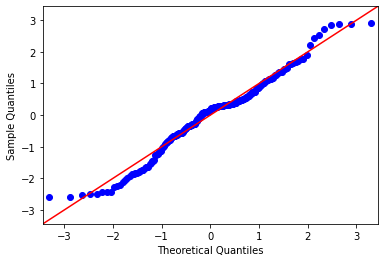

In [41]:
fig = sm.qqplot((residuals_pm[0].error[(residuals_pm[0].error < 900) & (residuals_pm[0].error > -900)]), stats.t, fit=True, line="45")
fig.show()

In [42]:
px.scatter(residuals_pm[0].error[(residuals_pm[0].error < 900) & (residuals_pm[0].error > -900)])

In [43]:
a = 0
score = 0
for i in range(len(residuals_pm)):
  a = a + (((residuals_pm[i].error[(residuals_pm[i].error < 900) & (residuals_pm[i].error > -900)])**2)**0.5).mean()
  u = ((residuals_pm[i].error)**2).sum()
  v = ((residuals_pm[i].expected)**2 - residuals_pm[0].expected.mean()**2).sum()
  score = score + 1-u/v

print('Physics-based linear model have a RMSE error of {}'.format(a/len(residuals_pm)))
print('Physics based linear model have a score of {}'.format(score/len(residuals_pm)))

Physics-based linear model have a RMSE error of 230.69441660529353
Physics based linear model have a score of 0.9748939791097034


### Simple Linear Model

In [44]:
models_sl, residuals_sl = train_linear_models(X_sl, y_sl)

In [45]:
for i in residuals_sl:
  i['error'] = i.expected.values-i.observed.values

In [46]:
px.histogram(residuals_pm[0]['error'], nbins=200)

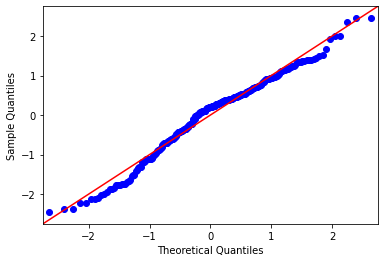

In [47]:
fig = sm.qqplot((residuals_sl[0].error[(residuals_sl[0].error < 900) & (residuals_sl[0].error > -900)]), stats.t, fit=True, line="45")
fig.show()

In [48]:
px.scatter(residuals_sl[0].error[(residuals_sl[0].error < 900) & (residuals_sl[0].error > -900)])

In [49]:
a = 0
score = 0
for i in range(len(residuals_sl)):
  a = a + (((residuals_sl[i].error[(residuals_sl[i].error < 900) & (residuals_sl[i].error > -900)])**2)**0.5).mean()
  u = ((residuals_sl[i].error)**2).sum()
  v = ((residuals_sl[i].expected)**2 - residuals_sl[0].expected.mean()**2).sum()
  score = score + 1-u/v

print('Simple linear model have a RMSE error of {}'.format(a/len(residuals_sl)))
print('Simple linear model have a score of {}'.format(score/len(residuals_sl)))

Simple linear model have a RMSE error of 281.2026755385254
Simple linear model have a score of 0.9701368624567389


##Observations




---


L - The residuals are almost normaly distribued<br>
M - Physics-based model have a higher score

## Label predict and malfunction detection

In [50]:
def pred_ac_power():
  g = float(input('Enter irradiance in kwh/15min: '))
  t = float(input('Enter ambient temperature in celsius: '))
  i = int(input('Enter the grid id: '))
  f = [g**3, g**2, (g**2)*t, g*(t**2), g*t, g]
  a = models_pm[i].predict(np.array(f).reshape(1, -1))
  mu, std = norm.fit((residuals_pm[i].error[(residuals_pm[i].error < 900) & (residuals_pm[i].error > -900)]))
  norm.interval(0.95, loc=mu, scale=std)
  return a

In [52]:
with open("models.pckl", "wb") as f:
  pickle.dump(models_pm, f)
